<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/FundusPhoto_crossvalidation3_VIT16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#変更点
・TIMMを導入→EfficientNetv2 (480px→回転→450px)<br>
・OptimizerにRangerAdabelief<br>
・平均と標準偏差による標準化は行っていない<br>
・回転の前に250px切り抜きを入れ、回転により画像が切れないようにした<br>
・GaussianBlurを入れて解析

In [1]:
from __future__ import print_function, division
!pip install torch_optimizer
!pip install timm

#!pip install adabelief-pytorch==0.1.0
!pip install ranger-adabelief==0.1.0
from ranger_adabelief import RangerAdaBelief

import timm
import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil
import csv
import pandas as pd
import glob
from PIL import Image
import sys
import statistics
import time


#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

#あればGPUを使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi -L

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')



     |████████████████████████████████| 72 kB 902 kB/s 
     |████████████████████████████████| 376 kB 4.1 MB/s 
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-af8e13bf-22ec-13df-849d-8aa467a6df22)
Mounted at /content/drive


In [7]:
name = "cropped_2"
model =  'vit16'
version = ""
if version is not "":
    version = "_"+str(version)

MODEL_NAME = name +"_"+model+version+"_pretrained"
DATASET_NAME = name+'_img_trainval'
DATASET_PATH = '/content/drive/MyDrive/Deep_learning/FundusPhoto'
PRETRAINED = True

os.chdir(DATASET_PATH)

TRAIN_FOLDER_NAME = 'train' #TRAINイメージのフォルダ
VAL_FOLDER_NAME = 'val' #VALイメージのフォルダ

FILENAME_LABELCSV = 'name_age.csv' #年齢の値のcsv
FILENAME_RESULTCSV = 'result_6.csv' #年齢推定結果を書き出すcsv
FILENAME_RESULT_ANALYSISCSV = 'result_analysis_6.csv' #推定結果の解析結果を書き出すcsv


MODEL_PATH = '/content/drive/MyDrive/Deep_learning/FundusPhoto/model'
#OPTIMIZER_PATH = "./optimizer_multi.pth"
LOG_PATH = "./log_multi.txt"
ROC_PATH = "./roc_multi.png"
CHECKPOINT_COUNT = 10
EPOCH = 100
PATIENCE = 20 #early stopping patience; how long to wait after last time validation loss improved.
BATCH_SIZE = 4


# transforms param
PX = 224 #画像のサイズ

#cropped_CLAHE_img
NORMALIZE_AVE = [0.543, 0.353, 0.228]
NORMALIZE_STD = [0.135, 0.11,  0.072]

TRAIN_CROP_SCALE =(0.85,1.0)
TRAIN_BRIGHTNESS_PARAM = 0.2
TRAIN_CONTRAST_PARAM = 0.1
TRAIN_SATURATION_PARAM = 0.1
TRAIN_RANDOM_ROTATION = 3
TRAIN_HUE_PARAM = 0.02


#csvファイルを開く
df_labelcsv = pd.read_csv(FILENAME_LABELCSV)

#csvファイルを表示
print(df_labelcsv)

#ID,ageの列の値をリストとして取り出す
df_filename = df_labelcsv['filename'].values
df_age = df_labelcsv['age'].values

#CSVファイル内の画像数
print(len(df_labelcsv))

"""
#画像フォルダ内の画像数
print(len(os.listdir(DATASET_NAME +"/"+ TRAIN_FOLDER_NAME))
+len(os.listdir(DATASET_NAME +"/"+ VAL_FOLDER_NAME))
+len(os.listdir(DATASET_NAME +"/"+ TEST_FOLDER_NAME)))
"""

                   filename  age
0     img00085008_00_1R.jpg   61
1     img00085024_00_1R.jpg   29
2     img00241280_10_1R.jpg   51
3     img00265140_00_1R.jpg   29
4     img00265140_00_2L.jpg   29
...                     ...  ...
1409  img76791392_10_1R.jpg   38
1410  img76843122_10_1R.jpg   49
1411  img76843122_11_1R.jpg   49
1412  img76888512_00_1R.jpg   74
1413  img76888512_00_2L.jpg   74

[1414 rows x 2 columns]
1414


'\n#画像フォルダ内の画像数\nprint(len(os.listdir(DATASET_NAME +"/"+ TRAIN_FOLDER_NAME))\n+len(os.listdir(DATASET_NAME +"/"+ VAL_FOLDER_NAME))\n+len(os.listdir(DATASET_NAME +"/"+ TEST_FOLDER_NAME)))\n'

#**Modules**

4.8 second


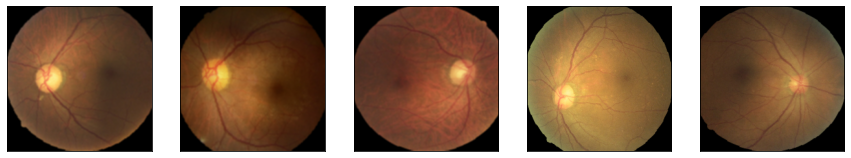

In [8]:
####################################
#Test with early-stopping
####################################

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print, device="cuda:0"):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.device =device
    def __call__(self, train_loss, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < train_loss/3:
                #val_loss<train_loss/3であれば保存しない（収束が早すぎる）
                self.trace_func('Excluded from counter due to too early convergence (val_loss<train_loss/3)')
                self.counter = 0
                #evaluator(model, device)
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model)
                self.counter = 0
                #evaluator(model, device)

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss



def train_model(model, loss_func, batch_size, optimizer, patience, n_epochs, device):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    #Optimize GPU computation
    torch.backends.cudnn.benchmark = True
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        running_corrects, train_acc= 0, 0


        scaler = torch.cuda.amp.GradScaler(enabled=True)

        for batch, (image_tensor, target) in enumerate(train_loader, 1):
            # convert batch-size labels to batch-size x 1 tensor
            #target = target.squeeze(1)
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model

            with torch.cuda.amp.autocast(enabled=True):
                output = model(image_tensor)      
                # calculate the loss
                loss = loss_func(output, target)

            # backward pass: compute gradient of the loss with respect to model parameters
            scaler.scale(loss).backward()
            # perform a single optimization step (parameter update)
            scaler.step(optimizer)

            # record training loss
            train_losses.append(loss.item())

            scaler.update()


        ######################    
        # validate the model #
        ######################
       
        model.eval() # prep model for evaluation

        running_corrects, val_acc= 0, 0

        for image_tensor, target in val_loader:  
            #target = target.squeeze(1)         
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +'\n'
                     f'train_loss: {train_loss:.5f} ' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' )
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(train_loss, valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses


#####################################
##### Evaluation of Accuracy #############
#####################################

def evaluator(model, device):
    model_ft.eval() # prep model for evaluation
    outputs,targets,errors =[], [], []
    for image_tensor, target in val_loader:  
          target = target.view(len(target), 1)         
          image_tensor = image_tensor.to(device)
          target = target.to(device)
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model_ft(image_tensor)

          outputs.append((output[0]*100).item())      
          targets.append((target[0]*100).item())
          #print('estimate R:'+str(my_round(output[0,0].item()))+'mm, L:'+str(my_round(output[0,1].item()))+'mm / target R:'+str(target[0,0].item())+'mm, L:'+str(target[0,1].item())+'mm')

          errors.append((output[0]*100).item()-(target[0]*100).item())
    
    AbsError = [abs(i) for i in errors]
    MeanError = str(statistics.mean(errors))
    StdError = str(statistics.stdev(errors))
    MeanAbsError = str(statistics.mean(AbsError))
    StdAbsError = str(statistics.stdev(AbsError))
    print("Validation set:")
    print('MeanError: '+MeanError)
    print('StdError: '+StdError)
    print('MeanAbsError: '+MeanAbsError)
    print('StdAbsError: '+StdAbsError)

    for image_tensor, target in train_loader:  
          target = target.view(len(target), 1)         
          image_tensor = image_tensor.to(device)
          target = target.to(device)
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model_ft(image_tensor)

          outputs.append((output[0]*100).item())      
          targets.append((target[0]*100).item())
          #print('estimate R:'+str(my_round(output[0,0].item()))+'mm, L:'+str(my_round(output[0,1].item()))+'mm / target R:'+str(target[0,0].item())+'mm, L:'+str(target[0,1].item())+'mm')

          errors.append((output[0]*100).item()-(target[0]*100).item())
    
    AbsError = [abs(i) for i in errors]
    MeanError = str(statistics.mean(errors))
    StdError = str(statistics.stdev(errors))
    MeanAbsError = str(statistics.mean(AbsError))
    StdAbsError = str(statistics.stdev(AbsError))
    print("Train set:")
    print('MeanError: '+MeanError)
    print('StdError: '+StdError)
    print('MeanAbsError: '+MeanAbsError)
    print('StdAbsError: '+StdAbsError)



#Calculating result

#対象のパスからラベルを抜き出して表示
def getlabel(result_csv, image_name):
      image_name = image_name
      label = df_result[df_result.iloc[:,0].str.contains(image_name)].iloc[0,1] #df_resultよりimage_nameが含まれる行を抜き出して年齢を取得
      return(image_name, label)


#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(224),
            #transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()])
    image_tensor = transform(image)


    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)


def my_round(x, d=0): #四捨五入
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p


#モデルにした処理した画像を投入して予測結果を出力
def image_eval(image_tensor, model_ft): 
    output = model_ft(image_tensor).item()*100
    return output

#result.csvに結果を記入
def write_result(df, image_name, pred, row):
    df.loc[df_result.iloc[:,0].str.contains(image_name), row] = pred  #df_resultよりimage_nameが含まれる行を抜き出して年齢を取得



#水増し後の画像を可視化する関数
def show_img(dataset):
    plt.figure(figsize=(15, 3))
    for i in range(5):
        image, label = dataset[i]
        #image = image.permute(1, 2, 0)
        image = image.numpy().transpose((1,2,0))
        image = np.clip(image, 0, 1)
        plt.subplot(1, 5, i+1)
        plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        plt.tick_params(bottom=False, left=False, right=False, top=False)
        plt.imshow(image)




#####################################
##### Datasets and Dataloader ############
#####################################

class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, csv_path, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = []
        self.item_dict = {}
        self.age = []

        for i in range(len(os.listdir(folder_path))):
              img_name = os.listdir(self.folder_path)[i]
              name = os.path.splitext(img_name)[0] #拡張子を削除したもの
              age_temp = df_labelcsv[df_labelcsv['filename'].str.contains(name)].iloc[0,1] #age
              self.age.append(float(age_temp)/100)

              img_path = os.path.join(self.folder_path, img_name)
              self.item_paths.append(img_path)
              #self.item_dict[image_path] = self.age


    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = read_image(image_path)
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.age[idx]])      
        return tensor_image, target


train_data_transforms = nn.Sequential(
                transforms.RandomResizedCrop(250, scale=TRAIN_CROP_SCALE),
                transforms.RandomRotation(degrees=10),
                transforms.CenterCrop(PX),
                transforms.GaussianBlur(3, sigma=(0.01, 3.0)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),        
                transforms.ConvertImageDtype(torch.float32),
                #transforms.Normalize(NORMALIZE_AVE, NORMALIZE_STD)
                )
val_data_transforms = nn.Sequential(
                transforms.Resize(PX),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ConvertImageDtype(torch.float32),
                #transforms.Normalize(NORMALIZE_AVE, NORMALIZE_STD)
                ) 
test_data_transforms = nn.Sequential(
                transforms.Resize(PX),
                transforms.ConvertImageDtype(torch.float32),
                #transforms.Normalize(NORMALIZE_AVE, NORMALIZE_STD)
                ) 


#画像の可視化
start_time = time.time()

train_dataset = SimpleImageDataset(os.path.join(DATASET_NAME, "1", TRAIN_FOLDER_NAME), FILENAME_LABELCSV, train_data_transforms)
show_img(train_dataset)

#print(train_dataset[1])

elapsed_time = round(time.time() - start_time, 2)
print(str(elapsed_time)+" second")



#**Select Algorithm**

In [ ]:
from pprint import pprint
pprint(timm.list_models(pretrained = True))

#**Data analysis**

In [11]:
#ワンタッチ解析（process, model(A2/B3), dataset(cropped, disc, macula, vascular))
#ここからがメイン
start_time = time.time()

name = ["cropped_2", "disc_2", "macula_2", "vascular_2_RGB"]
version =  'vit16'
if version is not "":
    version = "_"+str(version)

EPOCH = 160
PATIENCE = 20

process = [0,1,2,3,4]
for n in name:
        for i in process:
            print("Start "+str(n)+ ", " +str(i)+" th analysis!")
            DATASET_NAME = str(n) +'_img_trainval'
            MODEL_NAME = str(n) +version+"_pretrained"

            train_dataset = SimpleImageDataset(os.path.join(DATASET_NAME, str(i), TRAIN_FOLDER_NAME), FILENAME_LABELCSV, train_data_transforms)
            val_dataset = SimpleImageDataset(os.path.join(DATASET_NAME, str(i), VAL_FOLDER_NAME), FILENAME_LABELCSV,  val_data_transforms)

            train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers=os.cpu_count(), pin_memory=True)
            val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers=os.cpu_count(), pin_memory=True)

            #print(TRAIN_FOLDER_NAME + "_dataset_size：" + str(len(train_dataset)))
            #print(VAL_FOLDER_NAME + "_dataset_size：" + str(len(val_dataset)))

            ####################################
            #ConvNetの調整
            ####################################

            model_ft = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=1)

            #GPU使用
            model_ft = model_ft.to(device)

            #損失関数を定義
            loss_func = nn.MSELoss()

            #Optimizer
            #optimizer_ft = torch.optim.AdamW(model_ft.parameters(), 0.0002)
            """
            optimizer_ft = optim.AdaBound(
                model_ft.parameters(),
                lr= 1e-3,
                betas= (0.9, 0.999),
                final_lr = 0.1,
                gamma=1e-3,
                eps= 1e-8,
                weight_decay=0,
                amsbound=False,
            )
            """
            #optimizer_ft = AdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False)
            #optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999), weight_decouple = True)
            optimizer = optimizer.DiffGrad(
                model.parameters(),
                lr= 1e-3,
                betas=(0.9, 0.999),
                eps=1e-8,
                weight_decay=0,
            )

            ####################################
            # Train and Save network
            ####################################

            model, train_loss, valid_loss = train_model(model_ft, loss_func, BATCH_SIZE, optimizer_ft, PATIENCE, EPOCH, device)

            #ネットワークの保存
            PATH = MODEL_PATH+'/'+MODEL_NAME+'_'+str(i)+'.pth'
            torch.save(model_ft.state_dict(), PATH)

            ####################################
            # Result Analysis
            ####################################

            model_ft.eval() # prep model for evaluation

            outputs,targets,errors =[], [], []
            for image_tensor, target in val_loader:  
                  target = target.view(len(target), 1)         
                  image_tensor = image_tensor.to(device)
                  target = target.to(device)
                  # forward pass: compute predicted outputs by passing inputs to the model
                  output = model_ft(image_tensor)

                  outputs.append((output[0]*100).item())      
                  targets.append((target[0]*100).item())
                  #print('estimate R:'+str(my_round(output[0,0].item()))+'mm, L:'+str(my_round(output[0,1].item()))+'mm / target R:'+str(target[0,0].item())+'mm, L:'+str(target[0,1].item())+'mm')

                  errors.append((output[0]*100).item()-(target[0]*100).item())
            
            print("Validation set:")
            AbsError = [abs(i) for i in errors]
            MeanError = str(statistics.mean(errors))
            StdError = str(statistics.stdev(errors))
            MeanAbsError = str(statistics.mean(AbsError))
            StdAbsError = str(statistics.stdev(AbsError))

            print('MeanError: '+MeanError)
            print('StdError: '+StdError)
            print('MeanAbsError: '+MeanAbsError)
            print('StdAbsError: '+StdAbsError)

            
            #result_analysis.csv作成（ファイルがなければ）
            if os.path.exists(FILENAME_RESULT_ANALYSISCSV) == False:
                columns = []
                index = ["AveError", "StdError", "AveAbsError", "StdAbsError"]
                df_result_analysis = pd.DataFrame(index=index, columns=columns)
                df_result_analysis.to_csv(FILENAME_RESULT_ANALYSISCSV)
            else:
                print(FILENAME_RESULT_ANALYSISCSV + " already exists!")

            df_result_analysis = pd.read_csv(FILENAME_RESULT_ANALYSISCSV, index_col=0)
            df_result_analysis[MODEL_NAME+"_"+str(i)] = [MeanError, StdError, MeanAbsError, StdAbsError]


            PATH = MODEL_PATH+'/'+MODEL_NAME+'.csv'
            df_result_analysis.to_csv(FILENAME_RESULT_ANALYSISCSV, index=True)
            


            # Drawing learning curves
            # visualize the loss as the network trained
            fig = plt.figure(figsize=(10,8))
            plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
            plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

            # find position of lowest validation loss
            minposs = valid_loss.index(min(valid_loss))+1 
            plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

            plt.xlabel('epochs')
            plt.ylabel('loss')
            plt.ylim(0, 0.1) # consistent scale
            plt.xlim(0, len(train_loss)+1) # consistent scale
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()
            fig.savefig('loss_plot.png', bbox_inches='tight')



            #result.csv作成（ファイルがなければ）
            if os.path.exists(FILENAME_RESULTCSV) == False:
                df_result = df_labelcsv.copy()
                df_result.to_csv(FILENAME_RESULTCSV, index=False)
            else:
                print(FILENAME_RESULTCSV + " already exists!")

            df_result = pd.read_csv(FILENAME_RESULTCSV)
            #print(df_result)
            print("Calculating prediction results!")

            #valフォルダ内のファイル名を取得
            train_data_path = glob.glob(DATASET_NAME + "/" +str(i) + "/" + TRAIN_FOLDER_NAME+"/*")
            val_data_path = glob.glob(DATASET_NAME + "/" + str(i) + "/" + VAL_FOLDER_NAME+"/*")

            data_path = [train_data_path, val_data_path]
            k=0
            for j in data_path:
                for m in j:
                      #print(m)
                      #print(os.path.splitext(os.path.basename(m))[0])
                      image_name, label = getlabel(df_result, os.path.splitext(os.path.basename(m))[0])  #画像の名前（拡張子なし）とラベルを取得
                      image_tensor = image_transform(m)  #予測のための画像下処理
                      pred = image_eval(image_tensor, model_ft)  #予測結果を出力   
                      write_result(df_result, image_name, pred, MODEL_NAME+"_"+str(i))
                      #print(str(k)+"/"+str(len(df_result)) + " images processed! label: "+str(label)+ " , pred: "+str(pred))
                      k+=1
            #print(df_result)

            #Resultファイルを書き出し
            df_result.to_csv(FILENAME_RESULTCSV, index=False)


            # calculate elapsed time
            elapsed_time = int(time.time() - start_time)

            # convert second to hour, minute and seconds
            elapsed_hour = elapsed_time // 3600
            elapsed_minute = (elapsed_time % 3600) // 60
            elapsed_second = (elapsed_time % 3600 % 60)

            # print as 00:00:00
            print(str(elapsed_hour).zfill(2) + ":" + str(elapsed_minute).zfill(2) + ":" + str(elapsed_second).zfill(2))



Start cropped_2, 0 th analysis!


NameError: ignored

#**Load network**

In [ ]:
name = "macula_2"
model = "A2"  #A2 or B3

MODEL_NAME = name +"_"+model+"_pretrained"
DATASET_NAME = name+'_img_trainval'
DATASET_PATH = '/content/drive/MyDrive/Deep_learning/FundusPhoto'
NET_NAME = "RepVGG_" +model  #RepVGG_A2 or RepVGG_B3
PRETRAINED = True

TRAIN_FOLDER_NAME = 'train' #TRAINイメージのフォルダ
VAL_FOLDER_NAME = 'val' #VALイメージのフォルダ

FILENAME_LABELCSV = 'name_age.csv' #年齢の値のcsv
FILENAME_RESULTCSV = 'result_2.csv' #年齢推定結果を書き出すcsv
FILENAME_RESULT_ANALYSISCSV = 'result_analysis_2.csv' #推定結果の解析結果を書き出すcsv

MODEL_PATH = '/content/drive/MyDrive/Deep_learning/FundusPhoto/model'
#OPTIMIZER_PATH = "./optimizer_multi.pth"

if NET_NAME == "RepVGG_A2":
    model_ft = create_RepVGG_A2(deploy=False)

elif NET_NAME == "RepVGG_B3":
    model_ft = create_RepVGG_B3(deploy=False)

else:
    print("RepVGG_A2あるいはRepVGG_B3を指定して下さい")
    sys.exit(1)

#model_ft.load_state_dict(torch.load(MODEL_PATH)) 
model_ft = mod_RepVGG()

#GPU使用
model_ft = model_ft.to(device)

RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identit

In [ ]:
#ここからがメイン
process = [0,1,2,3,4]
for i in process:
    print("Start "+ str(i) + " th analysis!")

    #トレーニングしたパラメーターを適用
    PATH = MODEL_PATH+'/'+MODEL_NAME+'_'+str(i)+'.pth'
    model_ft.load_state_dict(torch.load(PATH))
    model_ft.eval()

    df_result = pd.read_csv(FILENAME_RESULTCSV)
    print(PATH)
    print("Calculating prediction results!")

    #valフォルダ内のファイル名を取得
    train_data_path = glob.glob(DATASET_NAME + "/" +str(i) + "/" + TRAIN_FOLDER_NAME+"/*")
    val_data_path = glob.glob(DATASET_NAME + "/" + str(i) + "/" + VAL_FOLDER_NAME+"/*")

    data_path = [train_data_path, val_data_path]
    preds,targets,errors =[], [], []
    k=0
    for j in data_path:
        for m in j:
              image_name, label = getlabel(df_result, os.path.splitext(os.path.basename(m))[0])  #画像の名前とラベルを取得
              image_tensor = image_transform(m)  #予測のための画像下処理
              pred = image_eval(image_tensor, model_ft)  #予測結果を出力   
              write_result(df_result, image_name, pred, MODEL_NAME+"_"+str(i))
              print(str(k)+"/"+str(len(df_result))+" th image: "+str(image_name)+", pred: "+str(my_round(pred, d=1))+", label: "+str(label))

              preds.append(pred)      
              targets.append(label)
              errors.append(pred-label)

              k+=1
    print(df_result)

    AbsError = [abs(i) for i in errors]
    MeanError = str(statistics.mean(errors))
    StdError = str(statistics.stdev(errors))
    MeanAbsError = str(statistics.mean(AbsError))
    StdAbsError = str(statistics.stdev(AbsError))
    print('MeanError: '+MeanError)
    print('StdError: '+StdError)
    print('MeanAbsError: '+MeanAbsError)
    print('StdAbsError: '+StdAbsError)
    print()

    #Resultファイルを書き出し
    df_result.to_csv(FILENAME_RESULTCSV, index=False)


In [ ]:
#######################
##1枚の画像のみを判定
#######################

print(MODEL_PATH)
print(MODEL_NAME)

#ファイル名を取得
img_name = "img00085008_00_1R.png"
img_path1 = "/content/drive/MyDrive/Deep_learning/FundusPhoto/"+name+"_img_trainval/0/train/"+img_name
img_path2 = "/content/drive/MyDrive/Deep_learning/FundusPhoto/"+name+"_img_trainval/0/val/"+img_name

for i in [img_path1, img_path2]:
    is_file = os.path.isfile(i)
    if is_file:
        img_path = i
        print("aaa")
    else:
        pass # パスが存在しないかファイルではない
        print("bbb")


outputs = []
for i in range(5):
    #トレーニングしたパラメーターを適用
    PATH = MODEL_PATH+'/'+MODEL_NAME+'_'+str(i)+'.pth'
    model_ft.load_state_dict(torch.load(PATH))
    model_ft.eval()

    df_result = pd.read_csv(FILENAME_RESULTCSV)
    print(MODEL_NAME+'_'+str(i)+'.pth')
    print("Calculating prediction results!")

    image_tensor = image_transform(img_path)  #予測のための画像下処理
    pred = image_eval(image_tensor, model_ft)  #予測結果を出力   

    outputs.append(pred)

print(outputs)

/content/drive/MyDrive/Deep_learning/FundusPhoto/model
macula_2_A2_pretrained
aaa
bbb
macula_2_A2_pretrained_0.pth
Calculating prediction results!
macula_2_A2_pretrained_1.pth
Calculating prediction results!
macula_2_A2_pretrained_2.pth
Calculating prediction results!
macula_2_A2_pretrained_3.pth
Calculating prediction results!
macula_2_A2_pretrained_4.pth
Calculating prediction results!
[44.820716977119446, 68.22026371955872, 54.96704578399658, 54.79089617729187, 50.11647343635559]
